In [576]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy import ndimage
import math
import keras
import ast
import operator as op
import re
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Suppressing warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [577]:
#Global Variable
dict_clean_img = {} #BINARY IMAGE DICTIONAY
dict_img = {} #ORIGINAL IMAGE DICTIONARY

#Keras support channel first (1,28,28) only
keras.backend.set_image_data_format("channels_first")


In [578]:
## Read the Image

In [579]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io, color
import matplotlib.pyplot as plt
import skimage.segmentation as seg

def slic_segmentation(img):
    segments = slic(img, n_segments=3000, compactness=15)
    rgb_arr=color.label2rgb(segments, img, kind='avg')
    return rgb_arr

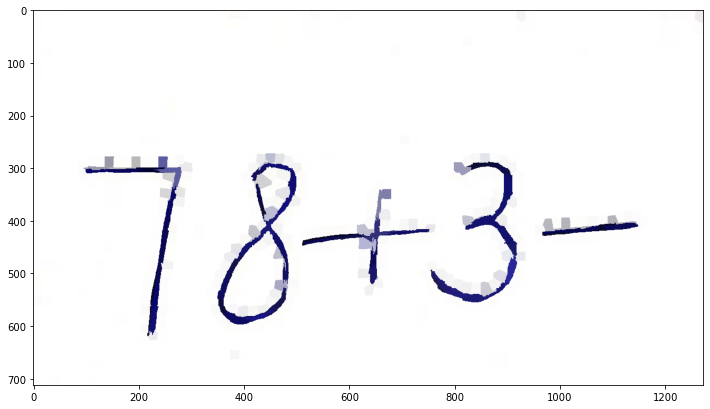

In [580]:
image_path = "C:/Users/jaina/Downloads/handwritten/Autograding-handwritten-mathematical-worksheets/data/aastha.jpeg"
A = 2
B = 2
X = 98
Y = 3
img = io.imread("C:/Users/jaina/Downloads/SLIC-master/SLIC-master/aadit2.jpeg")
img=slic_segmentation(img)
#img = cv2.imread(image_path)
plt.figure(figsize=(12,12))
plt.imshow(img)
img=img.astype(np.uint8)

In [581]:
try:
    model = keras.models.load_model('C:/Users/jaina/Downloads/DCNN_10AD_sy (1).h5', compile=False)

except Exception as e:
    print('Model couldnot be loaded',e)

In [582]:
def find_good_contours_thres(conts, alpha = 0.002):
    '''
    Function to find threshold of good contours on basis of 10% of maximum area
    Input: Contours, threshold for removing noises
    Output: Contour area threshold
    
    For image dim 3307*4676
    alpha(text_segment) = 0.01
    alpha(extract_line) = 0.002
    '''
    #Calculating areas of contours and appending them to a list
    areas = []
    
    for c in conts:
        areas.append([cv2.contourArea(c)**2])
    #alpha is controlling paramter    
    thres = alpha * max(areas)[0]
    
    return thres

In [583]:
def extract_line(image, beta=0.7, alpha=0.002, show = True):
    '''
    Function to extracts the line from the image   
    Assumption : Sufficient gap b/w lines
    
    argument:
        img (array): image array
        beta (0-1) : Parameter to differentiate line
        alpha (0-1) : Parameter to select good contours
        show(bool) : to show figures or not
    output:
        uppers[diff_index]  : Upper points (x,y)
        lowers[diff_index]  : lower points(x,y)
    '''
    img = image.copy()
    print(img)
    print(img.shape)
    H,W = img.shape[:2]
    h5 = int(.02 * H)
    w5 = int(.02 * W)
    print(h5)
    print(w5)
    print(img[:h5,:])
    img[:h5,:] = [255,255,255]
    img[-h5:,:] = [255,255,255]
    img[:,:w5] = [255,255,255]
    img[:,-w5:] = [255,255,255]
    print(img)
    #Converting image to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    print(gray)
    #Binary thresholding and inverting at 127
    th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
    
    #Selecting elliptical element for dilation    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dilation = cv2.dilate(threshed,kernel,iterations = 1)
    
    #Saving a copy of dilated image for taking bitwise_and operation
    temp = dilation.copy()
    
    # Find the contours
    if(cv2.__version__ == '3.3.1'): 
         xyz,contours,hierarchy = cv2.findContours(dilation,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    else:
        _, contours, _ = cv2.findContours(dilation,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
    cont_thresh = find_good_contours_thres(contours, alpha=alpha)

    #Creating a mask of only ones    
    mask = np.ones(dilation.shape[:2], dtype="uint8") * 255

    #Drawing those contours which are noises and then taking bitwise and
    for c in contours:
        if( cv2.contourArea(c)**2 < cont_thresh):
            cv2.drawContours(mask, [c], -1, 0, -1)
    
    cleaned_img = cv2.bitwise_and(temp, temp, mask=mask)
    
    #Dilating the cleaned image for better detection of line in cases where
    #exponents are little up the line
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dil_cleaned_img = cv2.dilate(cleaned_img,kernel,iterations = 10)
    
    #Getting back the cleaned original image without noise
    cleaned_orig = cv2.erode(cleaned_img, kernel, iterations=1) 
    
    ##find and draw the upper and lower boundary of each lines
    hist = cv2.reduce(dil_cleaned_img,1, cv2.REDUCE_AVG).reshape(-1)
    print(hist)
    th = 1
    H,W = img.shape[:2]
    print(H)
    print(W)
    uppers = np.array([y for y in range(H-1) if hist[y]<=th and hist[y+1]>th])
    lowers = np.array([y for y in range(H-1) if hist[y]>th and hist[y+1]<=th])
    print(uppers)
    print(lowers)
    diff_1 = np.array([j-i for i,j in zip(uppers,lowers)])
    print(diff_1)
    diff_index_1 = np.array([True if j > beta*(np.mean(diff_1)-np.std(diff_1)) else False for j in diff_1 ])
    print(diff_index_1)
    uppers = uppers[diff_index_1]
    print(uppers)
    lowers = lowers[diff_index_1]
    
    #Extending uppers and lowers indexes to avoid cutting of chars of lines
    #Extended more uppers by 33% as exponential might lie above 
    uppers[1:] = [i-int(j)/3 for i,j in zip(uppers[1:], diff_1[1:])]
    lowers[:-1] = [i+int(j)/4 for i,j in zip(lowers[:-1], diff_1[:-1])]
    
    diff_2 = np.array([j-i for i,j in zip(uppers,lowers)])
    diff_index_2 = np.array([True]*len(uppers))
    
    #Combining rogue exponentials into their deserving lines. This happens when
    #exponential and lines are separated by some distance
    for i,diff in enumerate(diff_2):
        if(i>0):
            if( (diff_2[i-1] < (diff/2)) and (( lowers[i-1]-uppers[i]) > ((lowers[i-1]-uppers[i-1])/5)) ):
                uppers[i] = uppers[i-1]
                diff_2[i] = diff_2[i]+diff_2[i-1]
                diff_index_2[i-1] = False
                print('Merging')

    diff_index = diff_index_2
    
    cleaned_orig_rec = cv2.cvtColor(cleaned_orig, cv2.COLOR_GRAY2BGR)
    
    #For changing color of intermediate lines, keeping count
    col_ct = 0
    
    for left,right in zip(uppers[diff_index], lowers[diff_index]):
        #print(left,right)
        col1 = (153,255,255)
        col2 = (255,255,153)
        if(col_ct % 2 == 0):
            col= col1
        else: 
            col=col2
        cv2.rectangle(cleaned_orig_rec ,(0+10,left),(W-15,right),col,4)
        col_ct += 1
        
    if(show == True):
        fig0 = plt.figure(figsize=(15,5))
        ax1 = fig0.add_subplot(1,3,1)
        ax1.set_title('Original Image')
        ax1.imshow(img)
        ax1.axis('off')
        
        ax2 = fig0.add_subplot(1,3,2)
        ax2.set_title('Cleaned Image')
        ax2.imshow(cleaned_img)
        ax2.axis('off')
        
        ax3 = fig0.add_subplot(1,3,3)
        ax3.set_title('Noises')
        ax3.imshow(mask)
        ax3.axis('off')
        
        fig0.suptitle('Denoising')
        plt.show()
    
        fig1 = plt.figure(figsize=(15,5))
        fig1.suptitle('Line Detection')
        ax1 = fig1.add_subplot(1,2,1)
        ax1.axis("off")
        ax1.imshow(cleaned_orig)
        
        ax2 = fig1.add_subplot(1,2,2)    
        ax2.axis("off")
        ax2.imshow(cleaned_orig_rec)
        
        plt.show()
    
    return cleaned_orig, uppers[diff_index], lowers[diff_index]

In [584]:
def sort_contours(cnts, method="left-to-right"):
    '''
    sort_contours : Function to sort contours
    argument:
        cnts (array): image contours
        method(string) : sorting direction
    output:
        cnts(list): sorted contours
        boundingBoxes(list): bounding boxes
    '''
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes       

    return (cnts, boundingBoxes)



In [585]:
def shift(img,sx,sy):
    '''
    Shift : Function to shift the image in given direction 
    argument:
        img (array) : gray scale image
        sx, sy      : x, y direction
    output:
        shifted : shifted image
    '''
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted

In [586]:
def getBestShift(img):
    '''
    getBestShift : Function to calculate centre of mass and get the best shifts
    argument:
        img (array) : gray scale image
    output:
        shiftx, shifty: x,y shift direction
    '''
    cy,cx = ndimage.measurements.center_of_mass(img)
    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty

In [587]:
def process_img (gray, resize_flag = 1, preproc = 0):
    '''
    process_img  : Function to pre process image for prediction
    argument:
        gray (Matrix (np.uint8))  : image of character to be resized and processed
        resize_flag               : method used for resizing image
        preproc (method [bool])   : 0 : No erosion DIlation, 1 : Erosion, Dilation
    output:
        grayS (Matrix (0-1))      : Normalised image of character resized and processed
    
    '''    
    gray = gray.copy()
    
    #Image Pre Processing
    if (preproc == 0):
        gray = cv2.GaussianBlur(gray,(7,7),0)
    else :
        kernel = np.ones((3,3), np.uint8)
        gray = cv2.dilate(gray, kernel, iterations=1)    
        gray = cv2.GaussianBlur(gray,(5,5),1)
        gray = cv2.dilate(gray, kernel, iterations=2)
        gray = cv2.erode(gray, kernel,iterations=2)    
    
    #Removing rows and columns where all the pixels are black
    while np.sum(gray[0]) == 0:
        gray = gray[1:]

    while np.sum(gray[:,0]) == 0:
        gray = np.delete(gray,0,1)

    while np.sum(gray[-1]) == 0:
        gray = gray[:-1]

    while np.sum(gray[:,-1]) == 0:
        gray = np.delete(gray,-1,1)

    rows,cols = gray.shape
    
    if(resize_flag) == 1:
        interpolation=cv2.INTER_AREA
    else:
        interpolation=cv2.INTER_CUBIC
    # Making the aspect ratio same before re-sizing
    if rows > cols:
        factor = 20.0/rows
        rows = 20
        cols = int(round(cols*factor))
        # first cols than rows
        gray = cv2.resize(gray, (cols,rows),interpolation=interpolation)
    else:
        factor = 20.0/cols
        cols = 20
        rows = int(round(rows*factor))
        # first cols than rows
        gray = cv2.resize(gray, (cols, rows),interpolation=interpolation)
   
    # Padding to a 28 * 28 image
    colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
    rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
    gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')
    
    # Get the best shifts
    shiftx,shifty = getBestShift(gray)
    shifted = shift(gray,shiftx,shifty)
    grayS = shifted
    grayS = grayS.reshape(1,1,28,28)
    
    #Normalize the image
    grayS = grayS/255
    
    return grayS


In [588]:
def predict(img,x1,y1,x2,y2, proba = False, acc_thresh = 0.60):
    '''
    predict  : Function to predict the character
    argument:
        x1,y1(int,int)    : Top left corner point
        x2,y2(int,int)    : Bottom right corner point
        acc_thresh(0-1)   : Probability threshold for calling model_robusta
        proba(bool)       : If probability values is wanted in return
    output:
        c[index](int) : predicted character 
    
    '''
    gray = img[y1:y2, x1:x2]

    # Steps to remove noises in image due to cropping
    temp = gray.copy()
    
    kernel_temp = np.ones((3,3), np.uint8) 
    temp_tmp = cv2.dilate(temp, kernel_temp, iterations=3)
    
    # Find the contours -  To check whether its disjoint character or noise
  
    _,contours_tmp,_ = cv2.findContours(temp_tmp,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
    if(len(contours_tmp) > 1):
        # Find the contours
        _,contours,_= cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        #Creating a mask of only zeros  
        mask = np.ones(gray.shape[:2], dtype="uint8") * 0
        # Find the index of the largest contour
        areas = [cv2.contourArea(c) for c in contours]
        max_index = np.argmax(areas)
        cnt=contours[max_index]
        
        cv2.drawContours(mask, [cnt], -1, 255, -1)
        #Drawing those contours which are noises and then taking bitwise and
        gray = cv2.bitwise_and(temp, temp, mask=mask)
        
    grayN = process_img (gray, resize_flag = 0)
    
    classes = model.predict(grayN, batch_size=2)
    ind = np.argmax(classes)
    c = ['0','1','2','3','4','5','6','7','8','9','+','-','*','(',')']

    
    if (proba == True):
        return classes[0][ind]
    
    return c[ind]

In [589]:
def text_segment(Y1,Y2,X1,X2, dict_clean = dict_clean_img,\
                 acc_thresh = 0.60, show = True):
    '''
    text_segment : Function to segment the characters
    Input:
        Box coordinates -X1,Y1,X2,Y2
        box_num - name of box
        line_name - name of line
        model - Deep Learning model to be used for prediction
        dict_clean - dictionary of clean box images
    Output :
        box_num - name of box
        line_name -name of line
        df_char - Dataframe of characters of that particular line
    '''
    img = dict_clean["r"][Y1:Y2,X1:X2].copy()
    L_H = Y2-Y1
    ## apply some dilation and erosion to join the gaps
    #Selecting elliptical element for dilation    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dilation = cv2.dilate(img,kernel,iterations = 2)
    erosion = cv2.erode(dilation,kernel,iterations = 1)
    
    # Find the contours
    if(cv2.__version__ == '3.3.1'):
        xyz,contours,hierarchy = cv2.findContours(erosion,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    else:
         _, contours, _  = cv2.findContours(erosion,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
    ct_th = find_good_contours_thres(contours, alpha=0.005)
    cnts = []
    for c in contours:       
        if( cv2.contourArea(c)**2 > ct_th):
            cnts.append(c)
    contours_sorted,bounding_boxes = sort_contours(cnts,method="left-to-right")
    char_locs = []
    
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    i = 0
    char_type =[]
    while i in range(0, len(contours_sorted)):
            x,y,w,h = bounding_boxes[i]
            exp = 0
            if i+1 != len(contours_sorted):
                x1,y1,w1,h1 = bounding_boxes[i+1]
                if abs(x-x1) < 10 and  (h1+h) < 70:
                    #print(h+h1)
                    minX = min(x,x1)
                    minY = min(y,y1)
                    maxX = max(x+w, x1+w1)
                    maxY = max(y+h, y1+h1)
                    x,y,x11,y11 = minX, minY, maxX, maxY
                    
                    x,y,w,h = x,y,x11-x,y11-y
                    i = i+2
                    continue
            
            #char_locs.append([x,y,x+w,y+h])     
            if(h<0.10*L_H and w<0.10*L_H):
                #print('Yes')
                i=i+1
                continue

            char_locs.append([x-2,y+Y1-2,x+w+1,y+h+Y1+1,w*h]) #Normalised location of char w.r.t box image
            
            cv2.rectangle(img,(x,y),(x+w,y+h),(153,180,255),2)

            if i!=0:
                if y+h < (L_H*(1/2)) and y < bounding_boxes[i-1][1] and h < bounding_boxes[i-1][3]:
                    exp = 1
                    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            i = i+1
            char_type.append(exp)
             
    

    df_char = pd.DataFrame(char_locs)
    df_char.columns=['X1','Y1','X2','Y2','area']
    df_char['exp'] = char_type
    df_char['pred'] = df_char.apply(lambda c: predict(dict_clean["r"],c['X1'],\
           c['Y1'],c['X2'], c['Y2'], acc_thresh=acc_thresh), axis=1 )
    df_char['pred_proba'] = df_char.apply(lambda c: predict(dict_clean["r"],c['X1'],\
           c['Y1'],c['X2'], c['Y2'], proba=True, acc_thresh=acc_thresh), axis=1 )
    df_char.apply(lambda c: cv2.putText(img, c['pred'], (c['X1']-10,35), cv2.FONT_HERSHEY_SIMPLEX,  
                   1.5,(147,96,247), 3, cv2.LINE_AA), axis=1) 

    if(show == True):        
        plt.figure(figsize=(15,8))   

        plt.axis("on")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
    	  
    return [df_char]


[[[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [240 236 235]
  [240 236 235]
  [240 236 235]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [240 236 235]
  [240 236 235]
  [240 236 235]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [240 236 235]
  [240 236 235]
  [240 236 235]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
(712, 1272, 3)
14
25
[[[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [240 236 235]
  [240 236 235]
  [240 236 235]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [240 236 235]
  [240 236 235]
  [240 236 235]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [240 236 235]
  [240 236 235]
  [240 236 235]]

 ...

 [[254 254 254]
  [254 254 254]

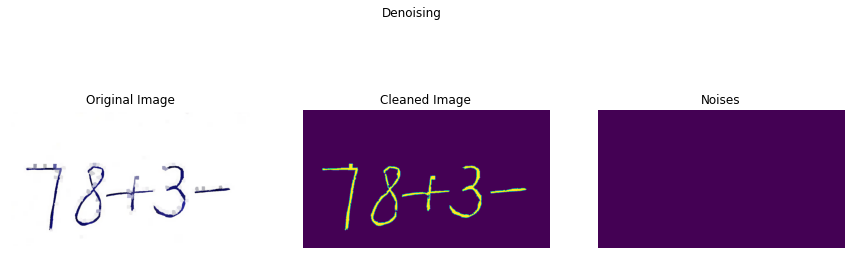

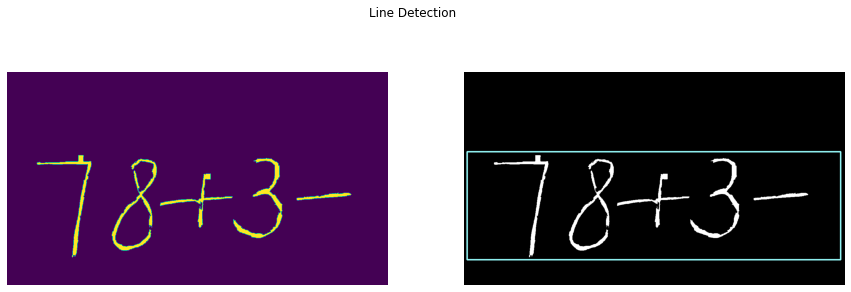

{'r': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}
    y1   y2  x1    x2
0  266  627   0  1272
    y1   y2  x1    x2
0  266  627   0  1272


In [590]:
df_lines = pd.DataFrame()

#Extracting lines present in the boxes
H,W = img.shape[:2]
cleaned_orig,y1s,y2s = extract_line(img, show=True)
x1s = [0]*len(y1s)
x2s = [W]*len(y1s)
    
# if(len(y1s)-len(y2s) == 0):
# print('Lines in workspace-%d : %d' %(r, len(y1s)))
    
df = pd.DataFrame([y1s,y2s,x1s,x2s]).transpose()
df.columns = ['y1','y2','x1','x2']

df_lines= pd.concat([df_lines, df])

dict_clean_img.update({"r":cleaned_orig})
print(dict_clean_img)
dict_img.update({"r":img})
    
print(df)
print(df)


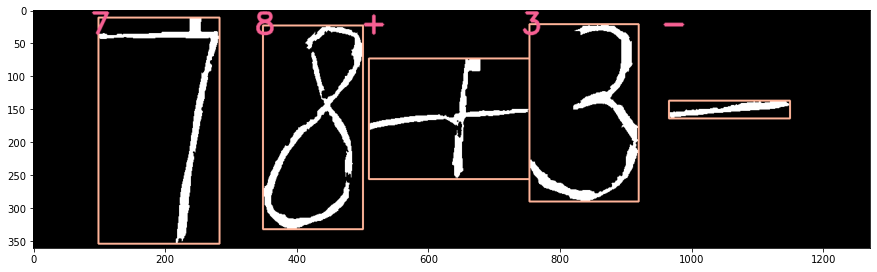

[[    X1   Y1    X2   Y2   area  exp pred  pred_proba
0   97  275   284  621  63112    0    7    0.820946
1  347  287   502  599  46968    0    8    0.556768
2  508  337   755  523  44652    0    +    0.858985
3  752  285   921  557  44654    0    3    0.988537
4  964  401  1151  431   4968    0    -    0.991822]]


In [592]:
#df_chars contains locations of all characters along with box_num and line name
list_chars = list(df.apply(lambda row: text_segment(row['y1'],row['y2'],\
                 row['x1'],row['x2'],\
                 show=True), axis=1))
print(list_chars)